In [1]:
import numpy as np
from numpy import *
from numpy.linalg import *
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import ranksums, ttest_ind, entropy, pearsonr, linregress
from scipy.io import savemat, loadmat
from scipy.interpolate import UnivariateSpline
import scipy.stats as stats
import scipy.io
from random import *
from itertools import combinations
from pylab import *
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import zlib
import os
import pandas as pd
from pyentrp import entropy as ent
from sklearn.linear_model import LinearRegression

#### SC

In [3]:
def calculate(istring: str, dl: int, sigma: float = 0.05, method: str = "overlapping",
                                     states_provided: bool = False, return_states: bool = False):
    """
    Find the (forwards) Statistical Complexity of an input string for given lambda and sigma values
    """
    #if states are not provided, find them, otherwise declare it
    if(type(states_provided)==bool):
        #first, find all states from the input string and the probabilities of presents
        initial_states = find_states(istring,dl,method=method)
        #next, collapse states which have similar probability distributions
        refined_states = collapse_states(initial_states,dl,sigma)
    else:
        #collapse the states based purely on keynames (already done)
        initial_states,refined_states = states_provided,states_provided
    #convert this into a list of probabilities
    probs = collapse_past(refined_states)
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    #if states are not desired, only return complexity
    if(return_states==False):
        return complexity
    else:
        return complexity,refined_states,initial_states

def calculate_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the (forwards) Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate(string,dl,sigma))
    return output

def calculate_bd(istring: str, dl: int, sigma: float = 0.05, method: str ="overlapping",
                              record_states: bool = False):
    """
    Find the forwards, reverse and bidirectional statistical complexity for a string
    """
    #find statistical complexity of forward string and the refined states
    f_sc,f_states,f_states_raw = calculate(istring,dl,sigma,return_states=True,method=method)
    #find complexity of backwards string
    b_sc,b_states,b_states_raw = calculate(istring[::-1],dl,sigma,return_states=True,method=method)
    #collapse the states of forward and reverse complexity based purely on key names
    bd_s = collapse_keys(f_states,b_states)
    #find complexity of bi-directional machine
    bd_sc,bd_states,bd_states_raw = calculate("",dl,sigma,states_provided = bd_s,return_states = True)
    if(record_states==False):
        return f_sc,b_sc,bd_sc
    else:
        return f_sc,b_sc,bd_sc,len(f_states),len(b_states),len(bd_states),len(f_states_raw),len(b_states_raw),len(bd_states_raw)

#Find multiple statistical complexities for forwards, reverse and bidirectional
def calculate_bd_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the forwards, reverse and bidirectional Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate_bd(string,dl,sigma))
    return output

#input string, desired lambda
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions
    """
    #variables used
    i,output_dict = 0,{}
    ## main loop of identifying past and present states
    # Option 1: Non Overlapping
    if(method=="nonoverlapping"):
        while(i+(dl*2)<len(istring)):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=dl
    #Option 2: Overlapping
    else:
        while(i+dl+1<len(istring)):
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=1
    # The last state discovery (main loop misses the final state that can be found)
    try:
        if(method=="nonoverlapping"):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
        else:
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
        if(past not in output_dict):
            output_dict.update({past: {present:1,"total":1}})
        else:
            if(present not in output_dict[past]):
                output_dict[past].update({present:1})
            else:
                output_dict[past][present]+=1
            output_dict[past]["total"]+=1
    except:
        pass
    #collapse counts into probabilities with total counts
    for past in output_dict:
        for present in output_dict[past]:
            if(present!="total"):
                output_dict[past][present]/=output_dict[past]["total"]
    return output_dict

def collapse_states(odict: dict, dl: int, sigma: float = 0.1):
    """
    Collapse a dictionary of state counts into practical states based on a permitted difference sigma
    """
    # Newdict is the collapsed dictionary, temp is used to override newdict when necessary,
    # done_checker is a dictionary used to record the keys already compared
    newdict,temp,done_checker = deepcopy(odict),False,{}
    while(True):
        # If temp is not a boolean, i.e. it's become a dictionary, override newdict
        if(type(temp)!=bool):
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if(past1 not in done_checker):
                done_checker[past1] = {}
            for past2 in newdict:
                if(past1!=past2):
                    if(past2 not in done_checker[past1]):
                        done_checker[past1][past2] = True
                    else:
                        # If these states have already been checked, don't bother checking them again
                        continue
                    # If the difference is less than sigma, merge these states and break the past2 loop
                    if(calculate_difference(newdict[past1],newdict[past2])<sigma):
                        temp = merge_states(newdict,past1,past2,dl)
                        break
            # If the dictionary must be updated, break the past1 loop
            if(type(temp)!=bool):
                break
        # If temp is still a boolean, i.e. there was no merging of states in this loop, break the main loop
        if(type(temp)==bool):
            break
    return newdict

def calculate_difference(past1: dict, past2: dict):
    """
    Calculate the difference between two past states' present state distributions
    """
    difference = -np.inf
    # Cycle through past 1 and check for max differences
    for present in past1:
        # Ensure this check isn't being performed on the total state count
        if(present!="total"):
            if(present not in past2):
                difference = max(difference,past1[present])
            else:
                difference = max(difference,abs(past1[present]-past2[present]))
    # Cycle through past 2
    for present in past2:
        if(present!="total"):
            if(present not in past1):
                difference = max(difference,past2[present])
    return difference

def merge_states(odict: dict, past1: dict, past2: dict, dl: int):
    """
    Merge 2 states and their present state distributions, creating a new state key in a standardised manner
    """
    nprobs = {}
    for present in odict[past1]:
        if(present in odict[past2]):
            nprobs.update({present:(odict[past1][present]+odict[past2][present])/2})
        else:
            nprobs.update({present:odict[past1][present]/2})
    for present in odict[past2]:
        if(present not in odict[past1]):
            nprobs.update({present:odict[past2][present]/2})
    nprobs.update({"total":odict[past1]["total"]+odict[past2]["total"]})
    #create a sorted version of the two pasts combined
    temp,to_sort = past1+past2,[]
    for i in range(int(len(temp)/dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while(len(to_sort)>0):
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    #add the new key and remove the old ones
    ndict = deepcopy(odict)
    ndict.update({newkey:nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

#collapse dictionary of past states and future states into an array of probabilities of the past states
def collapse_past(odict):
    """
    Collapse a dictionary of past states with present state distribtuions into an array of probabilities of the past states
    """
    probs,i,total = np.zeros(len(odict),dtype=float),0,0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i+=1
    return probs/total

def collapse_keys(d1: dict, d2: dict):
    """
    Merge 2 dictionaries of past states with present state distributions
    Note: keys present in both dictionaries lose their probability distributions and only the "total" key remains,
          but this is all that is needed by the point they are merged
    """
    ndict = {}
    for key in d1:
        # as longer keys are created and sorted in a standard way, they are all standardised
        temp = False
        if(key in d2):
            #if the key is in d2, add the two together and mark this has been done
            ndict.update({key:{"total":d1[key]["total"]+d2[key]["total"]}})
            temp = True
        #if no variant of the key was found in d2, add the key as-is
        if(temp==False):
            ndict.update({key:d1[key]})
    for key in d2:
        if(key not in ndict):
            ndict.update({key:d2[key]})
    return ndict

def probs_to_complexity(probs):
    """
    Calculate the Statistical Complexity given an array of past state probabilities
    """
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    # Correct any 0-probabilities to become 0 rather than infinity
    for i in range(len(logprobs)):
        if(probs[i]==0): logprobs[i] = 0.
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    return complexity

def binarise(data,mode="median"):
    """
    Binarise an array of continuous numbers into an array of 0's and 1's (as a string)
    """
    if(type(data)==list or type(data)==tuple):
        data=np.array(data,dtype=float)
    if(isinstance(data,np.ndarray)==False):
        return "Unusable datatype {}".format(type(data))
    if(mode=="median"):
        threshold=np.median(data)
    elif(mode=="mean"):
        threshold=np.mean(data)
    output = np.zeros([len(data)],dtype=int)
    for i in range(len(data)):
        if(data[i]>=threshold):
            output[i]+=1
    # Convert to string
    outstr = ""
    for element in output:
        outstr += str(element)
    return outstr

def multi_binarise(matrix,mode="median"):
    """
    Binarise a 2D matrix (used for calculating multiple statistical complexities)    
    """
    print("Binarising data...")
    # Convert to numpy matrix
    if(type(matrix)==list or type(matrix)==tuple):
        matrix=np.array(matrix,dtype=object)
    output = []
    percent_check = 0.
    for i in range(len(matrix)):
        output.append(binarise(matrix[i],mode))
        # Output progress
        if((i+1)/float(len(matrix))>=percent_check/100.):
            print("{}% of data binarised".format(\
                round(((i+1)/len(matrix))*100,1)))
            percent_check+=10.
    print("Data Binarised")
    return np.array(output, dtype = object)

### LZC

In [5]:
'''
Python code to compute LZc complexity measure as described in "Complexity of multi-dimensional spontaneous EEG decreases during propofol induced general anaesthesia"

Author: m.schartner@sussex.ac.uk
Date: 09.12.14

To compute Lempel-Ziv complexity for continuous multidimensional time series X, where rows are time series (minimum 2), and columns are observations, type the following in ipython: 
 
execfile('CompMeasures.py')
LZc(X)
'''

def Pre(X):
 '''
 Detrend and normalize input data, X a multidimensional time series
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro):
  Z[i,:]=signal.detrend(X[i,:]-mean(X[i,:]), axis=0)
 return Z


##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
'''
##########

def cpr(string):
    """
    Lempel-Ziv-Welch compression of binary input string, e.g., string='0010101'.
    It outputs the size of the dictionary of binary words.
    """
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZc_binary(string):
    """
    Compute LZ complexity for a binary string and normalize it using a shuffled result.
    """
    # Shuffling the string
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    # Calculate complexities
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity by the shuffled result if shuffled_complexity is not zero
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity


def str_col(X):
 '''
 Input: Continuous multidimensional time series
 Output: One string being the binarized input matrix concatenated comlumn-by-column
 '''
 ro,co=shape(X)
 TH=zeros(ro)
 M=zeros((ro,co))
 for i in range(ro):
  M[i,:]=abs(hilbert(X[i,:]))
  TH[i]=mean(M[i,:])

 s=''
 for j in xrange(co):
  for i in xrange(ro):
   if M[i,j]>TH[i]:
    s+='1'
   else:
    s+='0'

 return s

def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))

### Lyapunov

In [7]:
def calculate_lyapunov_exponent(data, r, epsilon=1e-10):
    """
    Calculate the Lyapunov exponent for the logistic map data.
    Args:
    - data (numpy array): The logistic map data.
    - r (float): The growth rate parameter of the logistic map.
    - epsilon (float): A small value to avoid log(0).
    Returns:
    - float: The Lyapunov exponent.
    """
    n = len(data)
    # Ensure the argument of the log function is never zero by adding epsilon
    log_argument = np.abs(r * (1 - 2 * data)) + epsilon
    lyapunov_exp = np.sum(np.log(log_argument)) / n
    return lyapunov_exp

### Logistic Map and White Noise

In [9]:
def logistic_map(r, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = r * x[i-1] * (1 - x[i-1])
        if x[i] < 0 or x[i] > 1:
            x[i] = np.nan  # Handle overflow by setting to NaN
    return x

# Function to add white noise
def add_white_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, size=data.shape)
    return data + noise

### Simulate

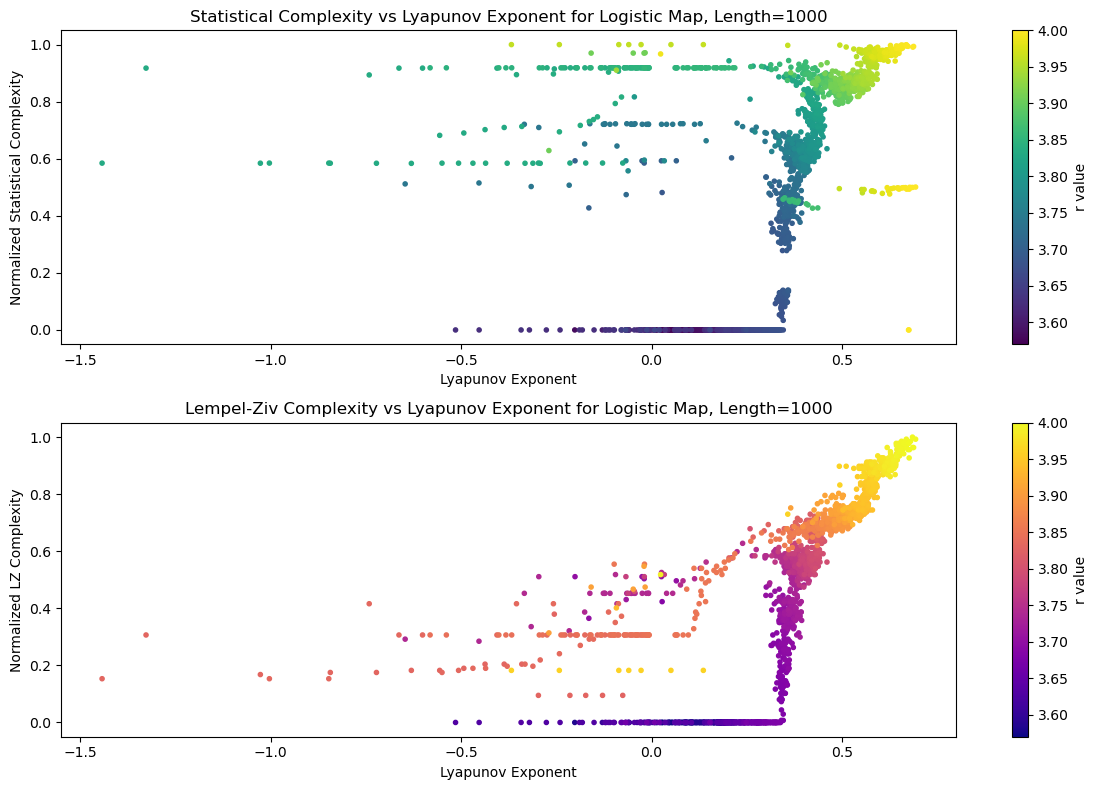

Length=1000:
Statistical Diverity vs Lyapunov Exponent: Correlation=0.4046, p-value=0.0000
LZ Complexity vs Lyapunov Exponent: Correlation=0.6731, p-value=0.0000


In [11]:
# Function to calculate Lyapunov exponent for logistic map
def calculate_lyapunov_exponent(data, r, epsilon=1e-10):
    n = len(data)
    log_argument = np.abs(r * (1 - 2 * data)) + epsilon
    lyapunov_exp = np.sum(np.log(log_argument)) / n
    return lyapunov_exp

# Function to generate data using logistic map with overflow handling
def logistic_map(r, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = r * x[i-1] * (1 - x[i-1])
        if x[i] < 0 or x[i] > 1:
            x[i] = np.nan  # Handle overflow by setting to NaN
    return x

# Function to calculate complexities
def calculate_statistical_complexity(sequence, lambda_val, sigma_val):
    binary_string = ''.join(sequence)
    return calculate(binary_string, lambda_val, sigma=sigma_val)

def LZc_binary(sequence):
    """
    Compute Lempel-Ziv complexity for a binary string.
    """
    return cpr(sequence)

# Function to binarize data
def binarize_data(data, threshold):
    return (data > threshold).astype(int)

# Normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Parameters for logistic map
r_values = np.linspace(3.57, 4, 2000) 
segment_lengths = [1000]
num_runs = 10  # Monte Carlo runs

# Store results for plotting
results = []

for length in segment_lengths:
    x0 = np.random.rand()
    for r in r_values:
        logistic_data = logistic_map(r, x0, length)
        if np.isnan(logistic_data).any():
            continue  # Skip this r value if overflow occurred
        
        binary_data = binarize_data(logistic_data, np.median(logistic_data))
        binary_string = ''.join(map(str, binary_data))

        # Calculate complexities
        stat_complexity = calculate_statistical_complexity(binary_string, lambda_val=2, sigma_val=0.05)
        lz_complexity = LZc_binary(binary_string)
        
        # Calculate Lyapunov exponent
        lyapunov_exp = calculate_lyapunov_exponent(logistic_data, r)
        
        results.append((r, length, stat_complexity, lz_complexity, lyapunov_exp))

# Convert results to a structured array
dtype = [('r', float), ('length', int), ('stat_complexity', float), ('lz_complexity', float), ('lyapunov_exponent', float)]
structured_results = np.array(results, dtype=dtype)

# Normalize complexities
normalized_stat_complexities = normalize(structured_results['stat_complexity'])
normalized_lz_complexities = normalize(structured_results['lz_complexity'])

# Plot results
for length in segment_lengths:
    r_vals = []
    stat_complexities = []
    lz_complexities = []
    lyapunov_exponents = []
    
    for result in structured_results:
        if result['length'] == length:
            r_vals.append(result['r'])
            stat_complexities.append(normalized_stat_complexities[np.where((structured_results['r'] == result['r']) & (structured_results['length'] == result['length']))[0][0]])
            lz_complexities.append(normalized_lz_complexities[np.where((structured_results['r'] == result['r']) & (structured_results['length'] == result['length']))[0][0]])
            lyapunov_exponents.append(result['lyapunov_exponent'])
    
    plt.figure(figsize=(12, 8))

    # Statistical Diverity vs Lyapunov Exponent
    plt.subplot(2, 1, 1)
    plt.scatter(lyapunov_exponents, stat_complexities, c=r_vals, cmap='viridis', label='Statistical Complexity', marker='.')
    plt.colorbar(label='r value')
    plt.title(f'Statistical Complexity vs Lyapunov Exponent for Logistic Map, Length={length}')
    plt.xlabel('Lyapunov Exponent')
    plt.ylabel('Normalized Statistical Complexity')
    #plt.grid(True)

    # Lempel-Ziv Complexity vs Lyapunov Exponent
    plt.subplot(2, 1, 2)
    plt.scatter(lyapunov_exponents, lz_complexities, c=r_vals, cmap='plasma', label='LZ Complexity', marker='.')
    plt.colorbar(label='r value')
    plt.title(f'Lempel-Ziv Complexity vs Lyapunov Exponent for Logistic Map, Length={length}')
    plt.xlabel('Lyapunov Exponent')
    plt.ylabel('Normalized LZ Complexity')
    #plt.grid(True)

    plt.tight_layout()

    file_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\Lyu_com.png'
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Correlation Analysis
    corr_stat, p_val_stat = pearsonr(lyapunov_exponents, stat_complexities)
    corr_lz, p_val_lz = pearsonr(lyapunov_exponents, lz_complexities)
    print(f'Length={length}:')
    print(f'Statistical Diverity vs Lyapunov Exponent: Correlation={corr_stat:.4f}, p-value={p_val_stat:.4f}')
    print(f'LZ Complexity vs Lyapunov Exponent: Correlation={corr_lz:.4f}, p-value={p_val_lz:.4f}')

### Simonsohn’s two-lines test of U-shaped relationship

In [13]:
# Function to find possible breakpoints in the data
def find_breakpoints(data, num_breakpoints=1000):
    """
    Find possible breakpoints in the data.
    """
    n = len(data)
    breakpoints = np.linspace(0, n, num_breakpoints, endpoint=False, dtype=int)
    return breakpoints[1:]  # Exclude the first point to avoid empty segment

# Function to perform linear regression and return the slope
def linear_regression(x, y):
    """
    Perform linear regression and return the slope.
    """
    model = LinearRegression()
    x = x.reshape(-1, 1)
    model.fit(x, y)
    slope = model.coef_[0]
    return slope

# Main function to apply the Two-Lines test to detect U-shaped relationship
def two_lines_test(data_x, data_y, breakpoints):
    """
    Apply the Two-Lines test to detect U-shaped relationship.
    """
    best_breakpoint = None
    best_slopes = (0, 0)
    max_diff = -np.inf
    is_u_shaped = False

    for bp in breakpoints:
        x_low, x_high = data_x[:bp], data_x[bp:]
        y_low, y_high = data_y[:bp], data_y[bp:]
        
        slope_low = linear_regression(x_low, y_low)
        slope_high = linear_regression(x_high, y_high)

        if slope_low * slope_high < 0:  # Sign change indicates potential U-shape
            slope_diff = abs(slope_low) + abs(slope_high)
            if slope_diff > max_diff:
                max_diff = slope_diff
                best_breakpoint = bp
                best_slopes = (slope_low, slope_high)
                is_u_shaped = True
    
    return best_breakpoint, best_slopes, is_u_shaped

In [14]:
# Parameters
noise_level = 0.1  # Noise level
segment_length = 4000  # Length of the logistic map data
r_values = np.linspace(3.57, 4, 2000)  # Range of r values

# Generate data and perform analysis
results = []
x0 = np.random.rand()
for r in r_values:
    logistic_data = logistic_map(r, x0, segment_length)
    if np.isnan(logistic_data).any():
        continue  # Skip this r value if overflow occurred

    # Add white noise
    noisy_data = add_white_noise(logistic_data, noise_level)

    # Binarize the data
    binary_data = binarize_data(noisy_data, np.median(noisy_data))
    binary_string = ''.join(map(str, binary_data))

    # Calculate complexities
    stat_complexity = calculate_statistical_complexity(binary_string, lambda_val=2, sigma_val=0.05)
    lz_complexity = LZc_binary(binary_string)

    # Calculate Lyapunov exponent
    lyapunov_exp = calculate_lyapunov_exponent(noisy_data, r)

    results.append((r, segment_length, stat_complexity, lz_complexity, lyapunov_exp))

# Convert results to a structured array
dtype = [('r', float), ('length', int), ('stat_complexity', float), ('lz_complexity', float), ('lyapunov_exponent', float)]
structured_results = np.array(results, dtype=dtype)

# Normalize complexities
normalized_stat_complexities = normalize(structured_results['stat_complexity'])
normalized_lz_complexities = normalize(structured_results['lz_complexity'])

### Apply Two-Lines test

In [16]:
breakpoints = find_breakpoints(structured_results['lyapunov_exponent'], num_breakpoints=50)
stat_results = two_lines_test(structured_results['lyapunov_exponent'], normalized_stat_complexities, breakpoints)
lz_results = two_lines_test(structured_results['lyapunov_exponent'], normalized_lz_complexities, breakpoints)

# Plotting and calculating slopes, p-values, and z-scores
# Extract data for plotting
lyapunov_exponents = structured_results['lyapunov_exponent']
r_vals = structured_results['r']

# Best breakpoints
stat_bp = stat_results[0]
lz_bp = lz_results[0]

# Function to calculate slope, intercept, and p-value
def calculate_slope_and_p_value(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, p_value

# Segments before and after breakpoint for Statistical Complexity
x_before_stat = lyapunov_exponents[:stat_bp]
y_before_stat = normalized_stat_complexities[:stat_bp]
x_after_stat = lyapunov_exponents[stat_bp:]
y_after_stat = normalized_stat_complexities[stat_bp:]

slope_before_stat, intercept_before_stat, p_value_before_stat = calculate_slope_and_p_value(x_before_stat, y_before_stat)
slope_after_stat, intercept_after_stat, p_value_after_stat = calculate_slope_and_p_value(x_after_stat, y_after_stat)

# Segments before and after breakpoint for Lempel-Ziv Complexity
x_before_lz = lyapunov_exponents[:lz_bp]
y_before_lz = normalized_lz_complexities[:lz_bp]
x_after_lz = lyapunov_exponents[lz_bp:]
y_after_lz = normalized_lz_complexities[lz_bp:]

slope_before_lz, intercept_before_lz, p_value_before_lz = calculate_slope_and_p_value(x_before_lz, y_before_lz)
slope_after_lz, intercept_after_lz, p_value_after_lz = calculate_slope_and_p_value(x_after_lz, y_after_lz)

### Plotting the results

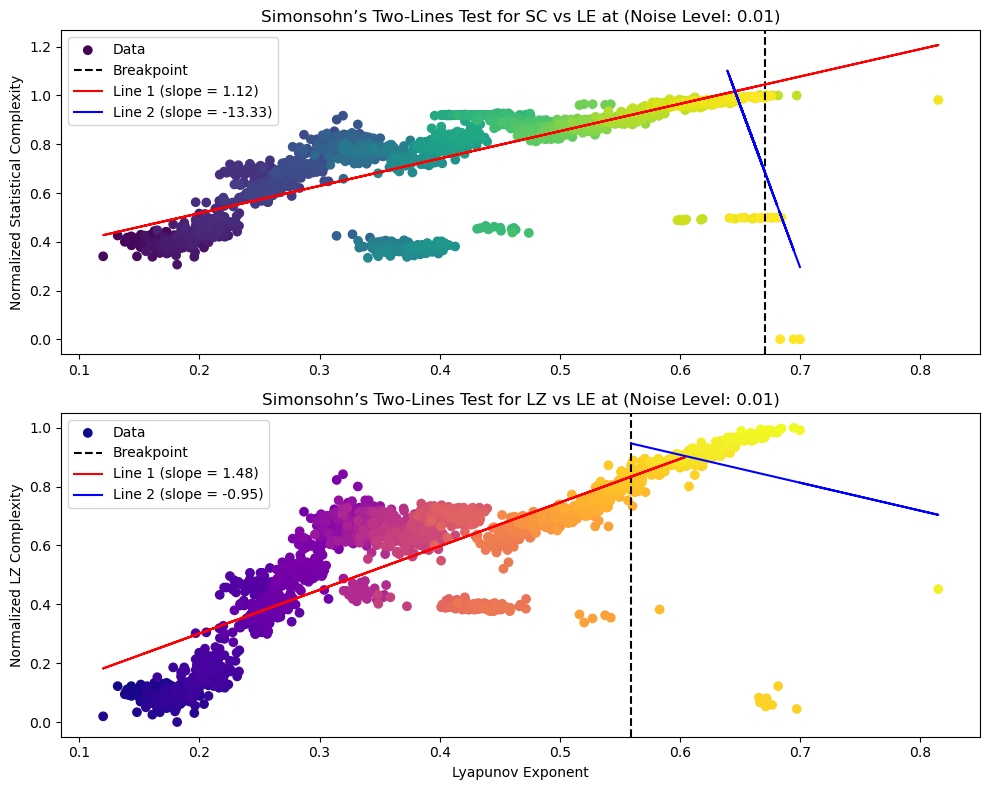

In [18]:
plt.figure(figsize=(10, 8))

# Statistical Complexity vs Lyapunov Exponent
plt.subplot(2, 1, 1)
plt.scatter(structured_results['lyapunov_exponent'], normalized_stat_complexities, c=structured_results['r'], cmap='viridis', label='Data')
plt.axvline(x=structured_results['lyapunov_exponent'][stat_bp], color='black', linestyle='--', label='Breakpoint')
plt.plot(x_before_stat, slope_before_stat * x_before_stat + intercept_before_stat, color='red', label=f'Line 1 (slope = {slope_before_stat:.2f})')
plt.plot(x_after_stat, slope_after_stat * x_after_stat + intercept_after_stat, color='blue', label=f'Line 2 (slope = {slope_after_stat:.2f})')
plt.title('Simonsohn’s Two-Lines Test for SC vs LE at (Noise Level: 0.01)')
plt.ylabel('Normalized Statistical Complexity')
plt.legend()

# Lempel-Ziv Complexity vs Lyapunov Exponent
plt.subplot(2, 1, 2)
plt.scatter(structured_results['lyapunov_exponent'], normalized_lz_complexities, c=structured_results['r'], cmap='plasma', label='Data')
plt.axvline(x=structured_results['lyapunov_exponent'][lz_bp], color='black', linestyle='--', label='Breakpoint')
plt.plot(x_before_lz, slope_before_lz * x_before_lz + intercept_before_lz, color='red', label=f'Line 1 (slope = {slope_before_lz:.2f})')
plt.plot(x_after_lz, slope_after_lz * x_after_lz + intercept_after_lz, color='blue', label=f'Line 2 (slope = {slope_after_lz:.2f})')
plt.title('Simonsohn’s Two-Lines Test for LZ vs LE at (Noise Level: 0.01)')
plt.xlabel('Lyapunov Exponent')
plt.ylabel('Normalized LZ Complexity')
plt.legend()

plt.tight_layout()
plt.show()

### Calculate z-scores for the slopes before and after the breakpoints

In [20]:
# Function to calculate z-score
def calculate_z_score(slope, std_err):
    return slope / std_err

# Calculate z-scores for Statistical Complexity
slope_before_stat, intercept_before_stat, r_value_before_stat, p_value_before_stat, std_err_before_stat = linregress(x_before_stat, y_before_stat)
slope_after_stat, intercept_after_stat, r_value_after_stat, p_value_after_stat, std_err_after_stat = linregress(x_after_stat, y_after_stat)
z_before_stat = calculate_z_score(slope_before_stat, std_err_before_stat)
z_after_stat = calculate_z_score(slope_after_stat, std_err_after_stat)

# Calculate z-scores for Lempel-Ziv Complexity
slope_before_lz, intercept_before_lz, r_value_before_lz, p_value_before_lz, std_err_before_lz = linregress(x_before_lz, y_before_lz)
slope_after_lz, intercept_after_lz, r_value_after_lz, p_value_after_lz, std_err_after_lz = linregress(x_after_lz, y_after_lz)
z_before_lz = calculate_z_score(slope_before_lz, std_err_before_lz)
z_after_lz = calculate_z_score(slope_after_lz, std_err_after_lz)

# Results with z-scores
results_with_z_scores = {
    "Statistical Complexity": {
        "Slope before breakpoint": slope_before_stat,
        "Slope after breakpoint": slope_after_stat,
        "P-value before breakpoint": p_value_before_stat,
        "P-value after breakpoint": p_value_after_stat,
        "Z-score before breakpoint": z_before_stat,
        "Z-score after breakpoint": z_after_stat
    },
    "Lempel-Ziv Complexity": {
        "Slope before breakpoint": slope_before_lz,
        "Slope after breakpoint": slope_after_lz,
        "P-value before breakpoint": p_value_before_lz,
        "P-value after breakpoint": p_value_after_lz,
        "Z-score before breakpoint": z_before_lz,
        "Z-score after breakpoint": z_after_lz
    }
}

# Display the final results with z-scores
results_with_z_scores

{'Statistical Complexity': {'Slope before breakpoint': 1.1217806475748673,
  'Slope after breakpoint': -13.329023778002632,
  'P-value before breakpoint': 2.1287751e-316,
  'P-value after breakpoint': 1.3292305894886989e-05,
  'Z-score before breakpoint': 46.26486174592976,
  'Z-score after breakpoint': -4.999617100514215},
 'Lempel-Ziv Complexity': {'Slope before breakpoint': 1.4829546486102712,
  'Slope after breakpoint': -0.9491806598385829,
  'P-value before breakpoint': 0.0,
  'P-value after breakpoint': 0.006374437842615196,
  'Z-score before breakpoint': 52.843034606865956,
  'Z-score after breakpoint': -2.7572373098486156}}